## Needed Libraries

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree

### Importing CSV Files

In [31]:
# Getting the Main DataFrame Ready
# Null values are checked beforehand in another notebook
# This dataframe was created from another notebook

df = pd.read_csv("trends_weekly_prices_df.csv")
df.index = df["Unnamed: 0"]
df.columns = ['Week', 'Trends', 'MeanPrices']
df.index.names = ['Week']
df.drop(['Week'],axis=1,inplace=True)
df['Week Feature'] = df.index
df

,Trends,MeanPrices,Week Feature
Week,,,
2017-01-22,5,1001.984641,2017-01-22
2017-01-29,5,858.134107,2017-01-29
2017-02-05,5,870.803750,2017-02-05
2017-02-12,5,914.227679,2017-02-12
2017-02-19,5,963.755536,2017-02-19
...,...,...,...
2020-11-29,22,18448.450613,2020-11-29
2020-12-06,18,18178.690735,2020-12-06
2020-12-13,28,19058.795087,2020-12-13


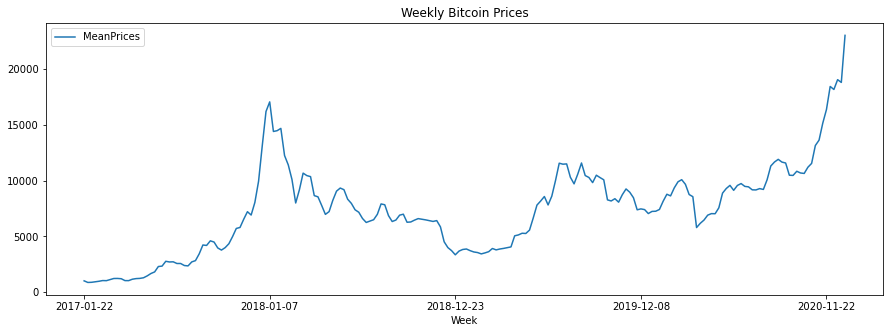

In [32]:
df[['MeanPrices']].plot(figsize=(15, 5))
plt.title("Weekly Bitcoin Prices")
plt.show()

In [33]:
# Converting dates as a datetime object

datelist_train = list(df['Week Feature'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
df.index = datelist_train
df

,Trends,MeanPrices,Week Feature
2017-01-22,5,1001.984641,2017-01-22
2017-01-29,5,858.134107,2017-01-29
2017-02-05,5,870.803750,2017-02-05
2017-02-12,5,914.227679,2017-02-12
2017-02-19,5,963.755536,2017-02-19
...,...,...,...
2020-11-29,22,18448.450613,2020-11-29
2020-12-06,18,18178.690735,2020-12-06
2020-12-13,28,19058.795087,2020-12-13
2020-12-20,29,18811.005779,2020-12-20


In [34]:
training_set = df.values
print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (206, 3).


array([[5, 1001.9846414285713, '2017-01-22'],
       [5, 858.134107142857, '2017-01-29'],
       [5, 870.8037499999998, '2017-02-05'],
       [5, 914.2276785714287, '2017-02-12'],
       [5, 963.7555357142858, '2017-02-19'],
       [7, 1027.1746414285717, '2017-02-26'],
       [7, 1017.6185714285713, '2017-03-05'],
       [6, 1112.9139271428571, '2017-03-12'],
       [6, 1212.71057, '2017-03-19'],
       [5, 1217.4027114285714, '2017-03-26'],
       [5, 1192.346425714286, '2017-04-02'],
       [5, 1023.576712857143, '2017-04-09'],
       [5, 1020.8408542857144, '2017-04-16'],
       [6, 1147.8891428571428, '2017-04-23'],
       [8, 1203.426282857143, '2017-04-30'],
       [10, 1221.2983199999999, '2017-05-07'],
       [12, 1277.5333928571429, '2017-05-14'],
       [19, 1447.7299985714287, '2017-05-21'],
       [13, 1659.5298214285715, '2017-05-28'],
       [13, 1803.6194642857145, '2017-06-04'],
       [15, 2287.1430328571428, '2017-06-11'],
       [12, 2324.5616042857146, '2017-06-18'

### Train and Test Splitting

In [35]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 June, 2019"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = df.loc[df.index <= dt_onject_split].copy()
data_test = df.loc[df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (126, 3)
Data test shape (80, 3)


In [36]:
def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth','Trends']]
    if label:
        y = df[label]
        return X, y
    return X



def create_features_without_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [37]:
# With trends
X_train, y_train = create_features_with_google_trends(data_train, label='MeanPrices')
X_test, y_test = create_features_with_google_trends(data_test, label='MeanPrices')

X_train['Trends'] = X_train['Trends'].astype(int)
X_test['Trends'] = X_test['Trends'].astype(int)


# Without trends
X_train_second, y_train_second = create_features_without_google_trends(data_train, label='MeanPrices')
X_test_second, y_test_second = create_features_without_google_trends(data_test, label='MeanPrices')

<ipython-input-37-18e8917dd981>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Trends'] = X_train['Trends'].astype(int)
<ipython-input-37-18e8917dd981>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Trends'] = X_test['Trends'].astype(int)


## Creating an xgboost model using google trends

In [38]:
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=True)

[10:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6094.28174	validation_1-rmse:10128.52441
[1]	validation_0-rmse:5602.93652	validation_1-rmse:9607.41602
[2]	validation_0-rmse:5244.12988	validation_1-rmse:9180.91992
[3]	validation_0-rmse:4933.84717	validation_1-rmse:8798.80371
[4]	validation_0-rmse:4661.85547	validation_1-rmse:8453.41602
[5]	validation_0-rmse:4427.53125	validation_1-rmse:8143.31201
[6]	validation_0-rmse:4128.42139	validation_1-rmse:7821.90820
[7]	validation_0-rmse:3955.87793	validation_1-rmse:7573.06982
[8]	validation_0-rmse:3805.92969	validation_1-rmse:7348.84473
[9]	validation_0-rmse:3682.72485	validation_1-rmse:7148.63525
[10]	validation_0-rmse:3480.25757	validation_1-rmse:7022.07324
[11]	validation_0-rmse:3391.58496	validation_1-rmse:6860.85693
[12]	validation_0-rmse:3317.89282	validation_1-rmse:6716.37598
[13]	validati

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [39]:
data_test['Trends_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)
data_all['MeanPrices'] = data_all['MeanPrices'].astype(float)
data_all['Trends_Price_Prediction'] = data_all['Trends_Price_Prediction'].astype(float)
data_all

,Trends,MeanPrices,Week Feature,Hafta,month,year,dayofmonth,Trends_Price_Prediction
2019-06-23,27,8603.515135,2019-06-23,2019-06-23,6,2019,23,7011.686523
2019-06-30,18,10005.623291,2019-06-30,2019-06-30,6,2019,30,6600.889160
2019-07-07,17,11560.661812,2019-07-07,2019-07-07,7,2019,7,5833.171875
2019-07-14,17,11473.037698,2019-07-14,2019-07-14,7,2019,14,5798.909180
2019-07-21,13,11496.810546,2019-07-21,2019-07-21,7,2019,21,4365.069824
...,...,...,...,...,...,...,...,...
2019-05-19,14,6647.705639,2019-05-19,2019-05-19,5,2019,19,NaN
2019-05-26,16,7800.502763,2019-05-26,2019-05-26,5,2019,26,NaN
2019-06-02,13,8167.206495,2019-06-02,2019-06-02,6,2019,2,NaN
2019-06-09,12,8571.252718,2019-06-09,2019-06-09,6,2019,9,NaN


Text(0.5, 1.0, 'With Google Trends')

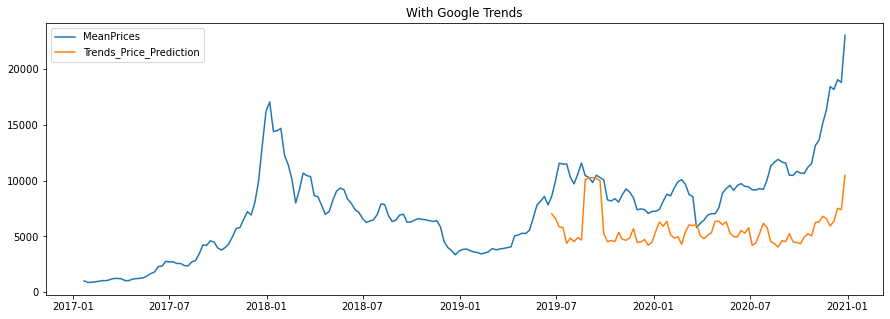

In [40]:
data_all[['MeanPrices','Trends_Price_Prediction']].plot(figsize=(15, 5))
plt.title("With Google Trends")

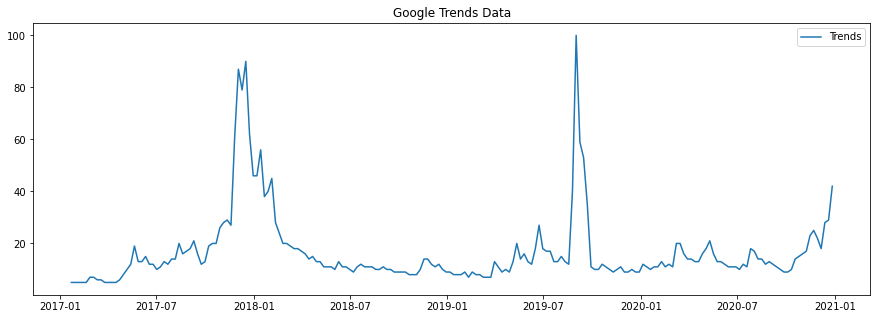

In [41]:
df[['Trends']].plot(figsize=(15, 5))
plt.title("Google Trends Data")
plt.show()

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae_with = mean_absolute_error(y_test, model.predict(X_test))

rmse_with = mean_squared_error(y_test, model.predict(X_test), squared=False)
print("Mean absolute error for with google trends: ",mae_with)
print("Root mean squared error for with google trends: ",rmse_with)



Mean absolute error for with google trends:  4544.2490673075035
Root mean squared error for with google trends:  5371.735929551641


## Creating an xgboost model without google trends

In [43]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

model_second =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
model_second.fit(X_train_second, y_train_second,eval_set=[(X_train_second, y_train_second), (X_test_second, y_test_second)],early_stopping_rounds=50,verbose=True)

[10:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6094.28174	validation_1-rmse:10128.52441
[1]	validation_0-rmse:5625.28564	validation_1-rmse:9730.97754
[2]	validation_0-rmse:5268.31055	validation_1-rmse:9304.44922
[3]	validation_0-rmse:4959.80762	validation_1-rmse:8922.25781
[4]	validation_0-rmse:4687.18506	validation_1-rmse:8574.75000
[5]	validation_0-rmse:4452.29395	validation_1-rmse:8262.74121
[6]	validation_0-rmse:4184.59814	validation_1-rmse:8048.49219
[7]	validation_0-rmse:4015.72339	validation_1-rmse:7800.08887
[8]	validation_0-rmse:3864.71777	validation_1-rmse:7575.14600
[9]	validation_0-rmse:3743.79761	validation_1-rmse:7374.65967
[10]	validation_0-rmse:3572.93213	validation_1-rmse:7247.64990
[11]	validation_0-rmse:3486.86206	validation_1-rmse:7086.11572
[12]	validation_0-rmse:3415.42895	validation_1-rmse:6941.30078
[13]	validati

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [44]:
data_test['Price_Prediction_Without_Trends'] = model_second.predict(X_test_second)
data_all_second = pd.concat([data_test, data_train], sort=False)
data_all_second['MeanPrices'] = data_all_second['MeanPrices'].astype(float)
data_all_second

,Trends,MeanPrices,Week Feature,Hafta,month,year,dayofmonth,Trends_Price_Prediction,Price_Prediction_Without_Trends
2019-06-23,27,8603.515135,2019-06-23,2019-06-23,6,2019,23,7011.686523,4483.521484
2019-06-30,18,10005.623291,2019-06-30,2019-06-30,6,2019,30,6600.889160,4955.810547
2019-07-07,17,11560.661812,2019-07-07,2019-07-07,7,2019,7,5833.171875,4635.057129
2019-07-14,17,11473.037698,2019-07-14,2019-07-14,7,2019,14,5798.909180,4372.092773
2019-07-21,13,11496.810546,2019-07-21,2019-07-21,7,2019,21,4365.069824,4189.918457
...,...,...,...,...,...,...,...,...,...
2019-05-19,14,6647.705639,2019-05-19,2019-05-19,5,2019,19,NaN,NaN
2019-05-26,16,7800.502763,2019-05-26,2019-05-26,5,2019,26,NaN,NaN
2019-06-02,13,8167.206495,2019-06-02,2019-06-02,6,2019,2,NaN,NaN
2019-06-09,12,8571.252718,2019-06-09,2019-06-09,6,2019,9,NaN,NaN


Text(0.5, 1.0, 'Without Google Trends')

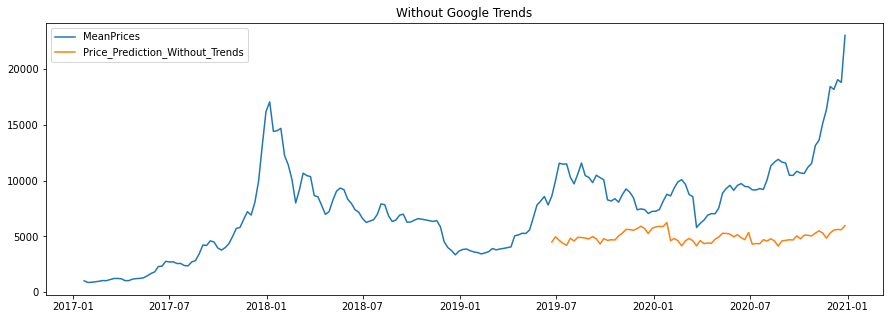

In [45]:
data_all_second[['MeanPrices','Price_Prediction_Without_Trends']].plot(figsize=(15, 5))
plt.title("Without Google Trends")

In [46]:
mae_without = mean_absolute_error(y_test_second, model_second.predict(X_test_second))
rmse_without = mean_squared_error(y_test_second, model_second.predict(X_test_second), squared=False)
print("Mean absolute error for without google trends: ",mae_without)
print("Root mean squared error for without google trends: ",rmse_without)

Mean absolute error for without google trends:  5256.78178150096
Root mean squared error for without google trends:  6052.070908327363


## Difference between with and without google trends

Mean absolute error for with google trends:  4544.2490673075035 <br/>
Root mean squared error for with google trends:  5371.735929551641  <br/>

Mean absolute error for without google trends:  5256.78178150096 <br/>
Root mean squared error for without google trends:  6052.070908327363 <br/>

Significant effect of google trends is observed.

In [18]:
# Previously train and test splitting was used for the data
# Now cross validation is used to further enhance our implementation

### Rolling Forecast Origin Implementation

In [19]:
def roll_forecast_orig(train,min_train_size,horizon):
    for i in range(len(train)-min_train_size-horizon+1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train,split_val

In [20]:
series_ex = [2300,5000,6000,9000,2323,5644,7878,4444,2342,3000,3500,5000,7000,8000,9000,8000]
test=series_ex[-2:]
train = series_ex[:-2]

rolling_data = roll_forecast_orig(train,min_train_size=3,horizon=2)

print('Training Set: {0}'.format(train))
print('Test Set: {0}'.format(test))

print('\n')

i= 0
for train_c, val_c in rolling_data:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    i += 1

Training Set: [2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500, 5000, 7000, 8000]
Test Set: [9000, 8000]


Count[1]
Train:	[[2300, 5000, 6000]]
Val:	[[9000, 2323]]
-------
Count[2]
Train:	[[2300, 5000, 6000, 9000]]
Val:	[[2323, 5644]]
-------
Count[3]
Train:	[[2300, 5000, 6000, 9000, 2323]]
Val:	[[5644, 7878]]
-------
Count[4]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644]]
Val:	[[7878, 4444]]
-------
Count[5]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878]]
Val:	[[4444, 2342]]
-------
Count[6]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444]]
Val:	[[2342, 3000]]
-------
Count[7]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342]]
Val:	[[3000, 3500]]
-------
Count[8]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000]]
Val:	[[3500, 5000]]
-------
Count[9]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500]]
Val:	[[5000, 7000]]
-------
Count[10]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 30

In [21]:
date_string = "21 June, 2019"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = df.loc[df.index <= dt_onject_split].copy()
data_test = df.loc[df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)
data_train

Data train shape (126, 3)
Data test shape (80, 3)


,Trends,MeanPrices,Week Feature
2017-01-22,5,1001.984641,2017-01-22
2017-01-29,5,858.134107,2017-01-29
2017-02-05,5,870.803750,2017-02-05
2017-02-12,5,914.227679,2017-02-12
2017-02-19,5,963.755536,2017-02-19
...,...,...,...
2019-05-19,14,6647.705639,2019-05-19
2019-05-26,16,7800.502763,2019-05-26
2019-06-02,13,8167.206495,2019-06-02
2019-06-09,12,8571.252718,2019-06-09


In [22]:
def create_features_with_google_trends_for_df(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['month'] = df['Hafta'].dt.month
    df['year'] = df['Hafta'].dt.year
    df['dayofmonth'] = df['Hafta'].dt.day

    
    X = df[['month','year','dayofmonth','Trends']]
    if label:
        y = df[label]
        return X, y
    return X

In [23]:
df_x, df_y = create_features_with_google_trends_for_df(data_train,"MeanPrices")
df_x_test, df_y_test = create_features_with_google_trends_for_df(data_test,"MeanPrices")

In [24]:
parameters_dict = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# example model
# model_cv =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
rolling_data_x = roll_forecast_orig(df_x,min_train_size=3,horizon=2)
rolling_data_y = roll_forecast_orig(list(df_y),min_train_size=3,horizon=2)


cv_x_train_list = []
cv_x_test_list = []
i= 0
for train_c, val_c in rolling_data_x:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    cv_x_train_list.append(train_c)
    cv_x_test_list.append(val_c)
    i += 1

Count[1]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5]
Val:	[            month  year  dayofmonth  Trends
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5]
-------
Count[2]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5]
Val:	[            month  year  dayofmonth  Trends
2017-02-19      2  2017          19       5
2017-02-26      2  2017          26       7]
-------
Count[3]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19  

2017-08-06      8  2017           6      14]
Val:	[            month  year  dayofmonth  Trends
2017-08-13      8  2017          13      20
2017-08-20      8  2017          20      16]
-------
Count[28]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
2017-02-26      2  2017          26       7
2017-03-05      3  2017           5       7
2017-03-12      3  2017          12       6
2017-03-19      3  2017          19       6
2017-03-26      3  2017          26       5
2017-04-02      4  2017           2       5
2017-04-09      4  2017           9       5
2017-04-16      4  2017          16       5
2017-04-23      4  2017          23       6
2017-04-30      4  2017          30       8
2017-05-07      5  2017           7      10
2017-05-14      5  2017          14      1

2017-12-03     12  2017           3      87]
Val:	[            month  year  dayofmonth  Trends
2017-12-10     12  2017          10      79
2017-12-17     12  2017          17      90]
-------
Count[45]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
2017-02-26      2  2017          26       7
2017-03-05      3  2017           5       7
2017-03-12      3  2017          12       6
2017-03-19      3  2017          19       6
2017-03-26      3  2017          26       5
2017-04-02      4  2017           2       5
2017-04-09      4  2017           9       5
2017-04-16      4  2017          16       5
2017-04-23      4  2017          23       6
2017-04-30      4  2017          30       8
2017-05-07      5  2017           7      10
2017-05-14      5  2017          14      1

2018-02-11      2  2018          11      28]
Val:	[            month  year  dayofmonth  Trends
2018-02-18      2  2018          18      24
2018-02-25      2  2018          25      20]
-------
Count[55]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
2017-02-26      2  2017          26       7
2017-03-05      3  2017           5       7
2017-03-12      3  2017          12       6
2017-03-19      3  2017          19       6
2017-03-26      3  2017          26       5
2017-04-02      4  2017           2       5
2017-04-09      4  2017           9       5
2017-04-16      4  2017          16       5
2017-04-23      4  2017          23       6
2017-04-30      4  2017          30       8
2017-05-07      5  2017           7      10
2017-05-14      5  2017          14      1

Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
...           ...   ...         ...     ...
2018-04-01      4  2018           1      17
2018-04-08      4  2018           8      16
2018-04-15      4  2018          15      14
2018-04-22      4  2018          22      15
2018-04-29      4  2018          29      13

[67 rows x 4 columns]]
Val:	[            month  year  dayofmonth  Trends
2018-05-06      5  2018           6      13
2018-05-13      5  2018          13      11]
-------
Count[66]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
...        

2018-11-25     11  2018          25      14]
-------
Count[94]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
...           ...   ...         ...     ...
2018-10-21     10  2018          21       8
2018-10-28     10  2018          28       8
2018-11-04     11  2018           4       8
2018-11-11     11  2018          11      10
2018-11-18     11  2018          18      14

[96 rows x 4 columns]]
Val:	[            month  year  dayofmonth  Trends
2018-11-25     11  2018          25      14
2018-12-02     12  2018           2      12]
-------
Count[95]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12 

[112 rows x 4 columns]]
Val:	[            month  year  dayofmonth  Trends
2019-03-17      3  2019          17       7
2019-03-24      3  2019          24       7]
-------
Count[111]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
...           ...   ...         ...     ...
2019-02-17      2  2019          17       9
2019-02-24      2  2019          24       8
2019-03-03      3  2019           3       8
2019-03-10      3  2019          10       7
2019-03-17      3  2019          17       7

[113 rows x 4 columns]]
Val:	[            month  year  dayofmonth  Trends
2019-03-24      3  2019          24       7
2019-03-31      3  2019          31      13]
-------
Count[112]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
201

In [25]:
cv_y_train_list = []
cv_y_test_list = []
i= 0
for train_c, val_c in rolling_data_y:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    cv_y_train_list.append(train_c)
    cv_y_test_list.append(val_c)

    i += 1

Count[1]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998]]
Val:	[[914.2276785714287, 963.7555357142858]]
-------
Count[2]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287]]
Val:	[[963.7555357142858, 1027.1746414285717]]
-------
Count[3]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858]]
Val:	[[1027.1746414285717, 1017.6185714285713]]
-------
Count[4]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858, 1027.1746414285717]]
Val:	[[1017.6185714285713, 1112.9139271428571]]
-------
Count[5]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858, 1027.1746414285717, 1017.6185714285713]]
Val:	[[1112.9139271428571, 1212.71057]]
-------
Count[6]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858, 1027.1746414285717, 1017.6185714285713, 1112.

In [26]:
# Validatio ile best hyperparamterları ayarla ve test set te  sonuçları predict et.



# Validation ile farklı hyperparametreleri test edip rootmeansquared value larını katşılaştırdım
# Sonra bunları karşılaştırıp aralarından en iyi sonuç veren hyperparametreleri alıp test setinde preedict ettirdim

In [27]:
def root_mean_squared_sum_of_list(list_value):
    sum_of_list_as_root_mean_squared = 0
    for i in list_value:
        sum_of_list_as_root_mean_squared += np.sqrt(i)
    return sum_of_list_as_root_mean_squared

def calculate_cv_scores(model,cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric):
    cv_scores = []
    i=0
    for i in range(len(cv_x_train_list)):
        model.fit(cv_x_train_list[i], cv_y_train[i])
        predictions = model.predict(cv_x_test_list[i])
        score = metric(y_true = cv_y_test[i], y_pred = predictions)
        cv_scores.append(score)
        i += 1
    return root_mean_squared_sum_of_list(np.array(cv_scores)) 
    

# Cross Validation function
def cross_val_score(cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric):

    parameters_dict = {"learning_rate"    : [0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8],
 "min_child_weight" : [ 5, 7 ],
 "gamma"            : [ 0.3, 0.4 ],
 "colsample_bytree" : [ 0.5 , 0.7 ] }
    
    cv_scores_dict = {}
    i_num = 0
    for l_r in parameters_dict['learning_rate']:
        for m_d in parameters_dict['max_depth']:
            for m_c_w in parameters_dict['min_child_weight']:
                for g in parameters_dict['gamma']:
                    for c_b in parameters_dict['colsample_bytree']:
                        model = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=m_c_w, booster='gbtree', colsample_bytree = c_b, learning_rate = l_r,max_depth = m_d)
                        hyper_parameter_string = "learning_rate "+str(l_r)+" max_depth "+str(m_d)+" min_child_weight "+str(m_c_w)+" gamma "+str(g)+" colsample_bytree "+str(c_b)
                        cv_score_of_model = calculate_cv_scores(model,cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric)
                        i_num = i_num + 1
                        print(str(i_num)+" Error of the model "+ hyper_parameter_string ,cv_score_of_model)
                        cv_scores_dict[hyper_parameter_string] = cv_score_of_model
    
    
    return cv_scores_dict

In [28]:
def find_least_error_hyperparameters(dictionary):
    min_index = 0
    key_list = []
    value_list = []
    for key,item in dictionary.items():
        key_list.append(key)
        value_list.append(item)
    temp_index = 0
    temp = value_list[0]
    for i in range(0,len(value_list)):
        if temp > value_list[i]:
            temp_index = i
            temp = value_list[i]
    return key_list[temp_index], temp

In [29]:
cv_sc = cross_val_score(cv_x_train_list , cv_x_test_list  ,cv_y_train_list, cv_y_test_list , mean_absolute_error)

1 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 4537.798467860229
2 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 4537.798467860229
3 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 4537.798467860229
4 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 4537.798467860229


KeyboardInterrupt: 

In [ ]:
# Cross validation scores for each train and validation cases (rolling forecast origin)
cv_sc

In [ ]:
best_hyperparameter, score = find_least_error_hyperparameters(cv_sc)

In [ ]:
best_hyperparameter

In [ ]:
# Normalde düüşük parametrelerde 7000 8000 değerlerini alıyordu
score

In [32]:
'''
Based on these hyperparameters i will create a new model and train and test using that model

'''

'\nBased on these hyperparameters i will create a new model and train and test using that model\n\n'

In [32]:
model = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=5, booster='gbtree', colsample_bytree = 0.5, learning_rate = 0.2,max_depth = 4)
model.fit(df_x,df_y)
predictions = model.predict(df_x_test)
error_m_s_tuned_hyperparameter = mean_squared_error(y_true = df_y_test, y_pred = predictions,squared=False)

In [33]:
error_m_s_tuned_hyperparameter

5092.176550161142

In [34]:
np.sqrt(error_m_s_tuned_hyperparameter)

71.35948815792572

## Sliding Window Cross Validation Example

In [36]:
def sliding_window(train,window_size,horizon):
    for i in range(len(train)-window_size-horizon+1):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size : window_size+i+horizon]
        yield split_train, split_val

In [37]:
cv_sliding = sliding_window(train,window_size=5,horizon=2)
print('Full Training Set: {0}\n'.format(train))

i=0
for train_c,val_c in cv_sliding:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    i += 1

Full Training Set: [2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500, 5000, 7000, 8000]

Count[1]
Train:	[[2300, 5000, 6000, 9000, 2323]]
Val:	[[5644, 7878]]
-------
Count[2]
Train:	[[5000, 6000, 9000, 2323, 5644]]
Val:	[[7878, 4444]]
-------
Count[3]
Train:	[[6000, 9000, 2323, 5644, 7878]]
Val:	[[4444, 2342]]
-------
Count[4]
Train:	[[9000, 2323, 5644, 7878, 4444]]
Val:	[[2342, 3000]]
-------
Count[5]
Train:	[[2323, 5644, 7878, 4444, 2342]]
Val:	[[3000, 3500]]
-------
Count[6]
Train:	[[5644, 7878, 4444, 2342, 3000]]
Val:	[[3500, 5000]]
-------
Count[7]
Train:	[[7878, 4444, 2342, 3000, 3500]]
Val:	[[5000, 7000]]
-------
Count[8]
Train:	[[4444, 2342, 3000, 3500, 5000]]
Val:	[[7000, 8000]]
-------


In [38]:
model_cv_sliding_w =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
sliding_w_x = sliding_window(df_x,window_size=5,horizon=2)
sliding_w_y = sliding_window(list(df_y),window_size=5,horizon=2)


sliding_cv_x_train_list = []
sliding_cv_x_val_list = []
i= 0
for train_c, val_c in sliding_w_x:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    sliding_cv_x_train_list.append(train_c)
    sliding_cv_x_val_list.append(val_c)
    i += 1

Count[1]
Train:	[            month  year  dayofmonth  Trends
2017-01-22      1  2017          22       5
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5]
Val:	[            month  year  dayofmonth  Trends
2017-02-26      2  2017          26       7
2017-03-05      3  2017           5       7]
-------
Count[2]
Train:	[            month  year  dayofmonth  Trends
2017-01-29      1  2017          29       5
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12       5
2017-02-19      2  2017          19       5
2017-02-26      2  2017          26       7]
Val:	[            month  year  dayofmonth  Trends
2017-03-05      3  2017           5       7
2017-03-12      3  2017          12       6]
-------
Count[3]
Train:	[            month  year  dayofmonth  Trends
2017-02-05      2  2017           5       5
2017-02-12      2  2017          12  

2018-10-14     10  2018          14       9]
Val:	[            month  year  dayofmonth  Trends
2018-10-21     10  2018          21       8
2018-10-28     10  2018          28       8]
-------
Count[88]
Train:	[            month  year  dayofmonth  Trends
2018-09-23      9  2018          23       9
2018-09-30      9  2018          30       9
2018-10-07     10  2018           7       9
2018-10-14     10  2018          14       9
2018-10-21     10  2018          21       8]
Val:	[            month  year  dayofmonth  Trends
2018-10-28     10  2018          28       8
2018-11-04     11  2018           4       8]
-------
Count[89]
Train:	[            month  year  dayofmonth  Trends
2018-09-30      9  2018          30       9
2018-10-07     10  2018           7       9
2018-10-14     10  2018          14       9
2018-10-21     10  2018          21       8
2018-10-28     10  2018          28       8]
Val:	[            month  year  dayofmonth  Trends
2018-11-04     11  2018           4       8
2

In [39]:
sliding_cv_y_train_list = []
sliding_cv_y_val_list = []
i= 0
for train_c, val_c in sliding_w_y:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    sliding_cv_y_train_list.append(train_c)
    sliding_cv_y_val_list.append(val_c)
    i += 1

Count[1]
Train:	[[1001.9846414285713, 858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858]]
Val:	[[1027.1746414285717, 1017.6185714285713]]
-------
Count[2]
Train:	[[858.134107142857, 870.8037499999998, 914.2276785714287, 963.7555357142858, 1027.1746414285717]]
Val:	[[1017.6185714285713, 1112.9139271428571]]
-------
Count[3]
Train:	[[870.8037499999998, 914.2276785714287, 963.7555357142858, 1027.1746414285717, 1017.6185714285713]]
Val:	[[1112.9139271428571, 1212.71057]]
-------
Count[4]
Train:	[[914.2276785714287, 963.7555357142858, 1027.1746414285717, 1017.6185714285713, 1112.9139271428571]]
Val:	[[1212.71057, 1217.4027114285714]]
-------
Count[5]
Train:	[[963.7555357142858, 1027.1746414285717, 1017.6185714285713, 1112.9139271428571, 1212.71057]]
Val:	[[1217.4027114285714, 1192.346425714286]]
-------
Count[6]
Train:	[[1027.1746414285717, 1017.6185714285713, 1112.9139271428571, 1212.71057, 1217.4027114285714]]
Val:	[[1192.346425714286, 1023.576712857143]]
-------
C

In [40]:
# Cross validation scores for each train and validation cases (sliding windows)
sliding_sc = cross_val_score(sliding_cv_x_train_list , sliding_cv_x_val_list  ,sliding_cv_y_train_list, sliding_cv_y_val_list , mean_absolute_error)

1 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 3322.2424472816297
2 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 3322.2424472816297
3 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 3322.2424472816297
4 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 3322.2424472816297
5 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 8735.186568989582
6 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 8735.186568989582
7 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 8735.186568989582
8 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 8735.186568989582
9 Error of the model learning_rate 0.2 max_d

69 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 8735.186568989582
70 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 8735.186568989582
71 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 8735.186568989582
72 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 8735.186568989582
73 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 3322.2423670937114
74 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 3322.2423670937114
75 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 3322.2423670937114
76 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 3322.2423670937114
77 Error of the model learni

In [41]:
best_hyperparameter_sliding_window, error_sliding_window = find_least_error_hyperparameters(sliding_sc)

In [42]:
print("Best hyperparameters for sliding window cross validation: ",best_hyperparameter_sliding_window)

Best hyperparameters for sliding window cross validation:  learning_rate 0.25 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5


In [43]:
print("Error value for sliding window cross validation: ",error_sliding_window)

Error value for sliding window cross validation:  3322.2423670937114


In [44]:
model_sw = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=5, booster='gbtree', colsample_bytree = 0.5, learning_rate = 0.25,max_depth = 3,gamma = 0.3)
model_sw.fit(df_x,df_y)
predictions_sw = model.predict(df_x_test)
error_m_s_tuned_hyperparameter = mean_squared_error(y_true = df_y_test, y_pred = predictions_sw,squared=False)

In [45]:
error_m_s_tuned_hyperparameter

5092.176550161142

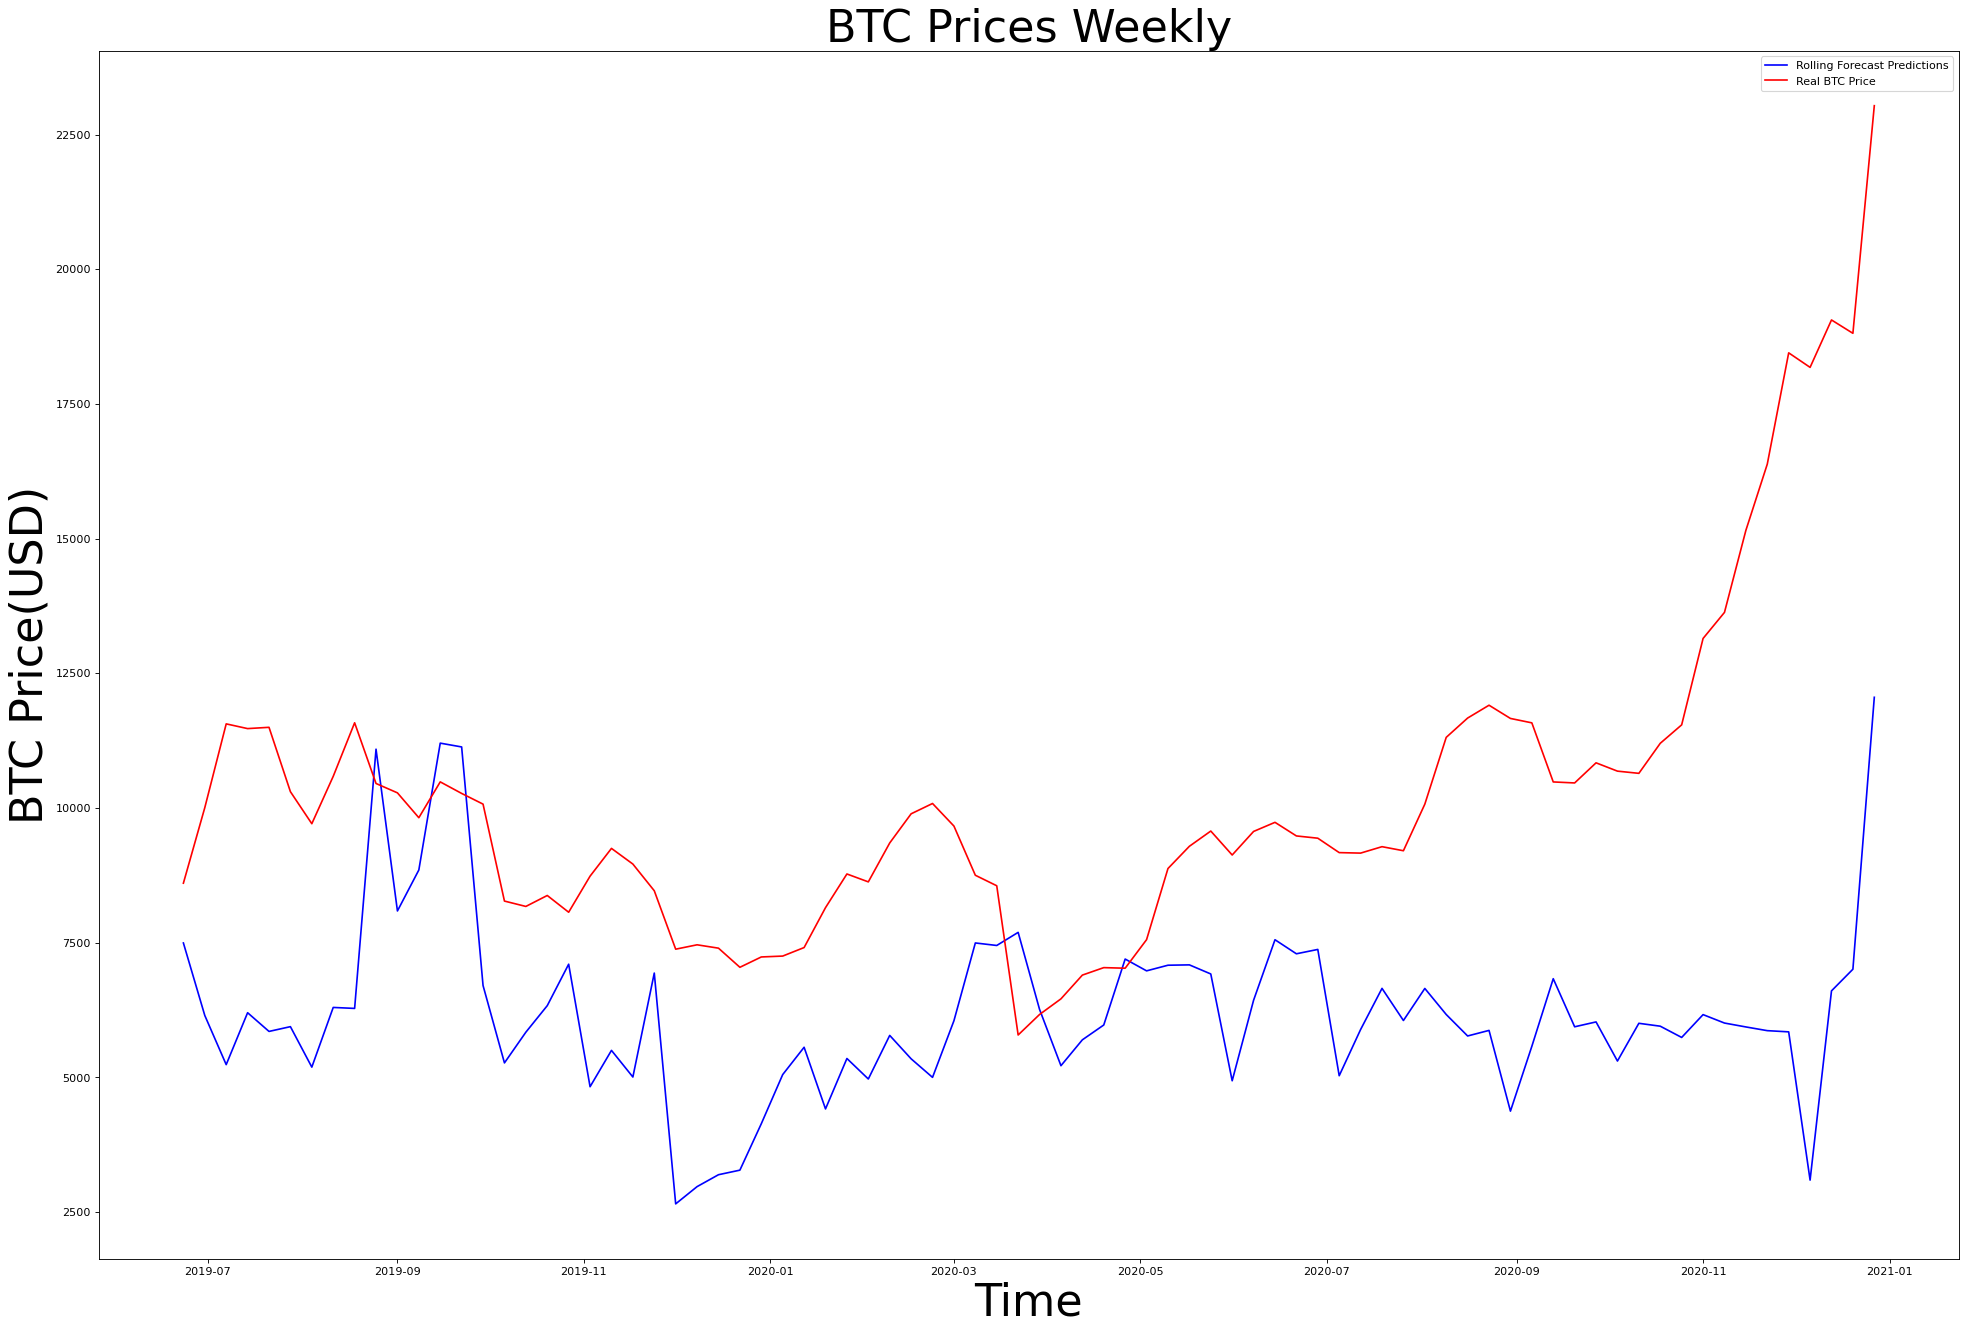

In [48]:
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(df_x_test.index,predictions, color='blue', label='Rolling Forecast Predictions')
plt.plot(df_x_test.index,df_y_test, color='red', label='Real BTC Price')
# Same values are predicted with sliding window
#plt.plot(df_x_test.index,predictions_sw, color='green', label='Real BTC Price')
plt.title('BTC Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend()
plt.show()

In [ ]:
    # 3840 possible parameters
    '''
{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
    
    '''